In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# EDO

$dy/dt + ky = 0$

# Solução Analítica

$y(t)=Ce^{−kt}$

In [2]:
def plot_values_over_time(t_values, y_values, label=None, xlabel='Tempo', ylabel='Valor', title=None):
    plt.plot(t_values, y_values, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)
    plt.show()

def plot_exponential_function(t_values, label=None, xlabel='Tempo', ylabel='Valor', title=None):
    y_values = np.exp(-t_values)  # Calcular os valores da função exponencial

    plt.plot(t_values, y_values, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, hidden_size, output_size=1,input_size=1):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.LeakyReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.LeakyReLU()
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.LeakyReLU()
        self.l4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        out = self.relu3(out)
        out = self.l4(out)
        return out

In [4]:
# Create the criterion that will be used for the DE part of the loss
criterion = nn.MSELoss()

# Define the loss function for the initial condition
def initial_condition_loss(y, target_value):
    return nn.MSELoss()(y, target_value)

In [5]:
# Time vector that will be used as input of our NN
t_numpy = np.arange(0, 5+0.01, 0.01, dtype=np.float32)
t = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
t.requires_grad_(True)

# Constant for the model
k = 1

# Instantiate one model with 50 neurons on the hidden layers
model = NeuralNet(hidden_size=50)

# Loss and optimizer
learning_rate = 8e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Number of epochs
num_epochs = int(1e4)

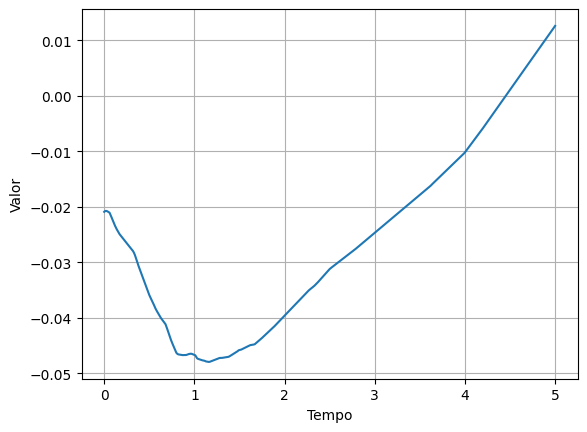

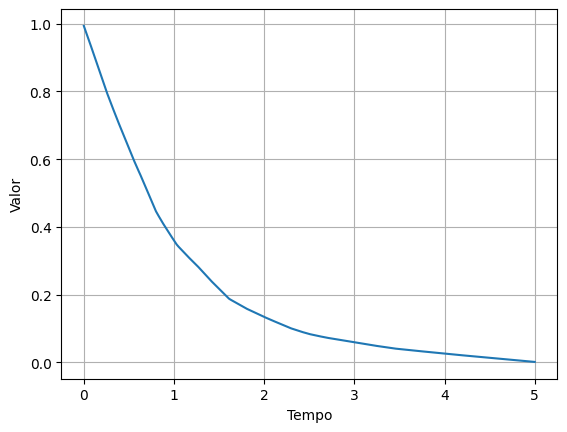

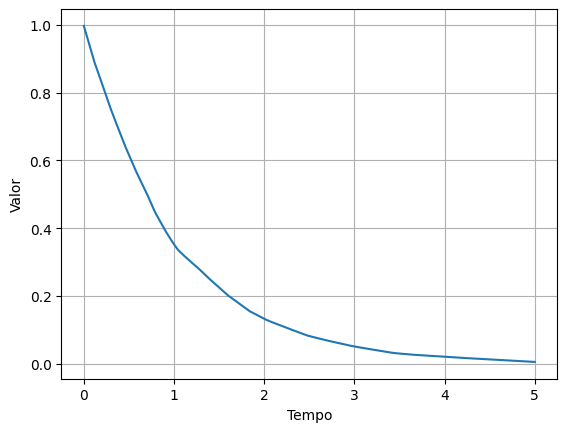

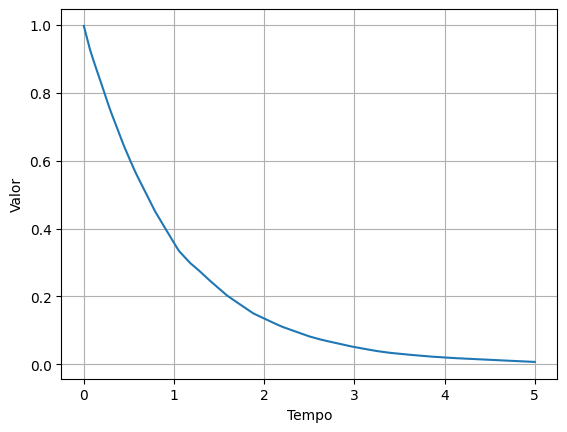

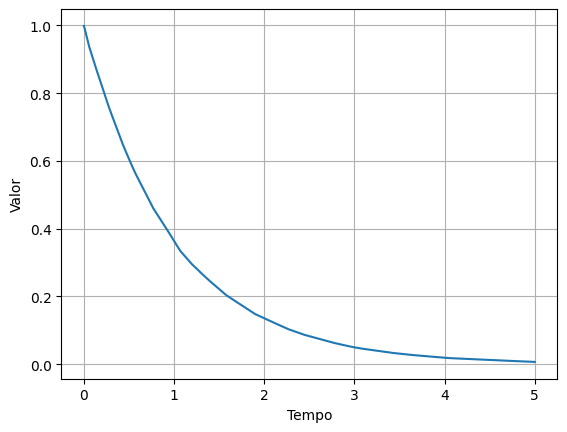

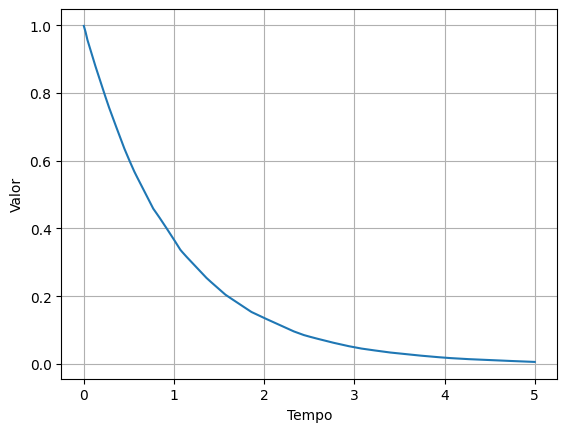

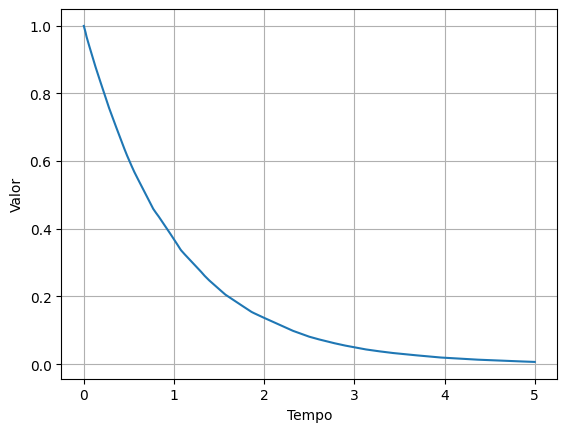

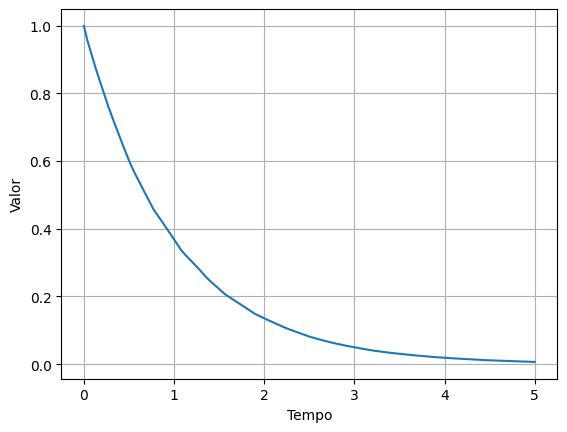

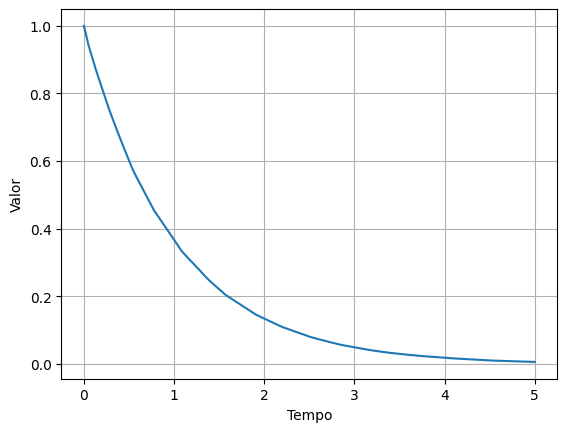

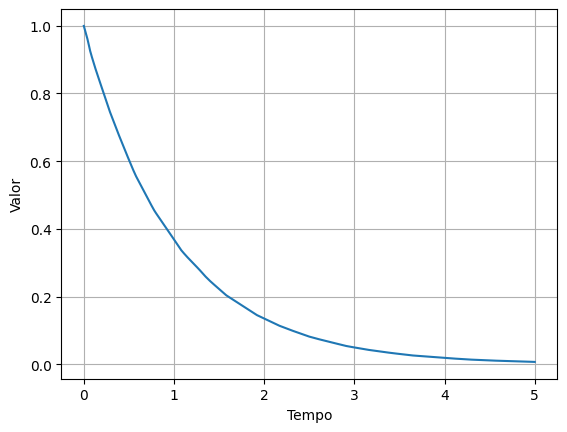

In [6]:
for epoch in range(num_epochs):
    # Randomly perturbing the training points to have a wider range of times
    epsilon = torch.normal(0,0.1, size=(len(t),1)).float()
    t_train = t + epsilon
    t_train = t_train

    # Forward pass
    y_pred = model(t_train)

    # Calculate the derivative of the forward pass w.r.t. the input (t)
    dy_dt = torch.autograd.grad(y_pred,
                                t_train,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]

    # Define the differential equation and calculate the loss
    loss_DE = criterion(dy_dt + k*y_pred, torch.zeros_like(dy_dt))

    # Define the initial condition loss
    loss_IC = initial_condition_loss(model(torch.tensor([[0.0]])), torch.tensor([[1.0]]))

    loss = loss_DE + loss_IC

    # Backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        y_track = model(t)
        plot_values_over_time(t.detach().numpy(), y_track.detach().numpy())

    print(f'iter: {epoch}', end='\r')

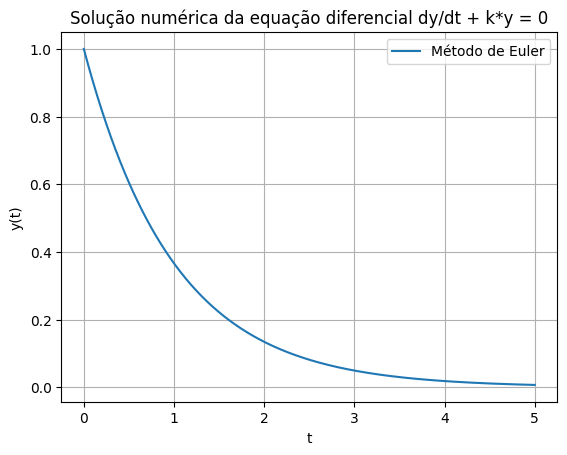

In [7]:
# Função que define a equação diferencial dy/dt + k*y = 0
def diff_eq(y, k):
    return -k * y

# Método de Euler para resolver a equação diferencial
def euler_method(y0, k, t0, tn, h):
    num_steps = int((tn - t0) / h)  # Número de passos
    t_values = np.linspace(t0, tn, num_steps + 1)  # Array de valores de t
    y_values = np.zeros(num_steps + 1)  # Array de valores de y
    y_values[0] = y0  # Condição inicial

    # Iteração para calcular os valores de y usando o método de Euler
    for i in range(num_steps):
        y_values[i + 1] = y_values[i] + h * diff_eq(y_values[i], k)

    return t_values, y_values

# Parâmetros
y0 = 1.0  # Condição inicial: y(0)
k = 1  # Constante k na equação diferencial
t0 = 0    # Tempo inicial
tn = 5   # Tempo final
h = 0.01   # Tamanho do passo

# Resolver a equação diferencial usando o método de Euler
t_values, y_values = euler_method(y0, k, t0, tn, h)

# Plotar os resultados
plt.plot(t_values, y_values, label='Método de Euler')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Solução numérica da equação diferencial dy/dt + k*y = 0')
plt.legend()
plt.grid(True)
plt.show()

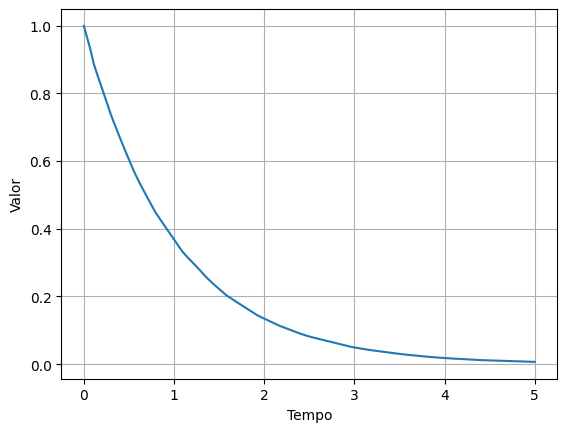

In [8]:
y_track = model(t)
plot_values_over_time(t.detach().numpy(), y_track.detach().numpy())

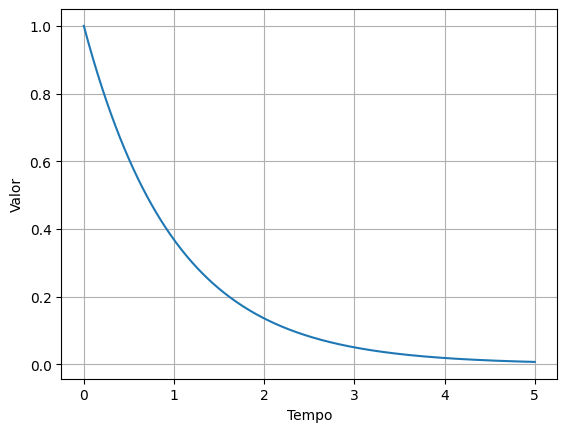

In [9]:
plot_exponential_function(t.detach().numpy())

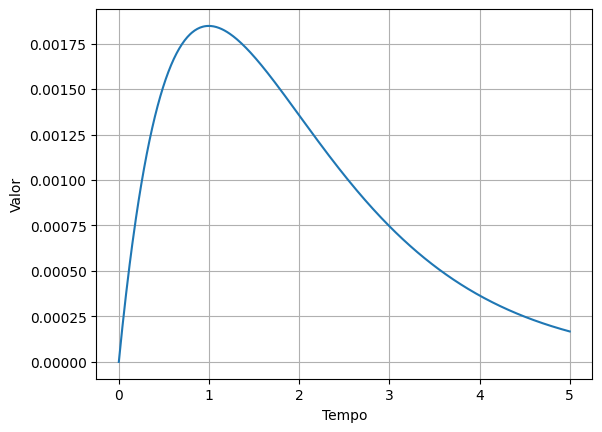

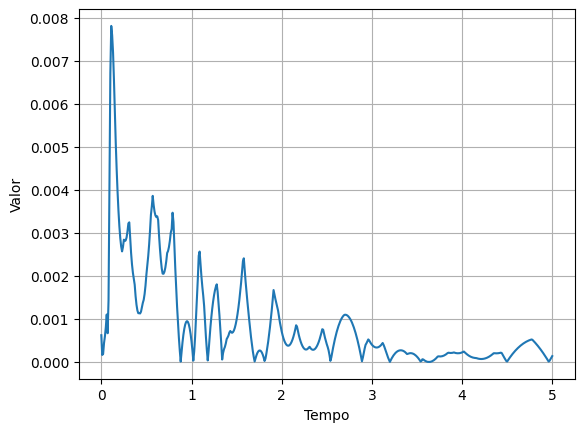

In [10]:
t_np = t.detach().numpy()
y_real = np.exp(-t_np)
y_euler = y_values.reshape(-1, 1)

#erro euler
plot_values_over_time(t_np, np.abs(y_real-y_euler))


y_pred = model(t)
y_nn = y_pred.detach().numpy()
plot_values_over_time(t_np, np.abs(y_real-y_nn))